# Generative Adversarial Networks (GANs)

## Background
### What are GANs?

Generative adversarial networks (GANs) are models used to generate new data that resembles real data. They consist of two parts: the generator and the discriminator.

- Generator: This part of the GAN creates new data. It takes in random noise and transforms it into data that looks similar to what it has been trained on, like images, music, or text.
- Discriminator: This component evaluates the data generated by the generator. It tries to distinguish between real data (the data it was trained on) and the fake data produced by the generator.
As the generator and discriminator compete, the generator learns to make more realistic data, and the discriminator gets better at telling real from fake.

![GANS.jpg](https://github.com/cameronervin/NN-Projects/blob/main/independent_projects/GANs/images/GANS.jpg?raw=true)

**Major Use Cases:**

- Image generation: Creating new images that look like they could be real, such as artwork or photo enhancements.
- Text generation: Producing realistic text sequences for applications like chatbots.
- Music and video generation: Composing music or creating video clips that appear to be human-made.
- Data augmentation: Generating additional data for training machine learning models, especially when original data is scarce.
- Anomaly detection: Identifying unusual patterns or outliers in data, which is useful in fields like cybersecurity or healthcare.

### Origins and Evolution

The evolution of Generative Adversarial Networks (GANs) has been marked by significant developments since their inception:

**Original GAN (2014):**
- Introduced by Ian Goodfellow and his colleagues, the original GAN framework consisted of the basic setup with a generator and a discriminator competing against each other. This model could generate relatively simple images.

**Deep Convolutional GAN (DCGAN, 2015):**
- DCGANs introduced the use of convolutional neural networks (CNNs), which are particularly good for image processing. This improvement allowed GANs to generate much higher quality images.

**Conditional GAN (cGAN, 2016):**
- cGANs provided a way to direct the generation process by conditioning the model on additional information, such as class labels. This meant that users could specify what kind of images to generate.

**BigGAN (2018):**
- BigGAN scaled up the size and complexity of GANs, using more data and computational power to produce very high-quality images. It demonstrated that larger models and batch sizes can significantly improve the realism and variety of generated images.

**StyleGAN (2018) and StyleGAN2 (2019):**
- StyleGAN introduced a novel generator architecture that could control specific aspects of the generated images (like style and structure) at different scales. StyleGAN2 further refined this approach to improve image quality and training stability.

**Diffusion Models (2021 onwards):**
- Although not traditional GANs, diffusion models have taken a central stage in the generative models landscape, often achieving results superior to GANs in generating images, with more stable training processes and higher-quality results.

![tweet.png](https://github.com/cameronervin/NN-Projects/blob/main/independent_projects/GANs/images/tweet.png?raw=true)

## Code
We will now implement vanilla GANs.

In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
import warnings

warnings.filterwarnings('ignore')

In [2]:
colab = True

if colab:
    # mount to google drive from colab
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile
    with zipfile.ZipFile('/content/drive/MyDrive/dogs_big.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data')
        zip_ref.close()

    data_path = "/content/data/dogs_big"

Mounted at /content/drive


In [3]:
def plot_images(directory_path, title="Image Grid"):
    # list all files in the directory
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(('png', 'jpg', 'jpeg', 'bmp'))]

    # create a 4x4 grid for displaying images
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    fig.suptitle(title, fontsize=20)

    # loop through grid and add images
    for ax, file in zip(axes.ravel(), files):
        # open image, resize it and display it
        img = Image.open(file).resize((128, 128))
        ax.imshow(img)
        ax.axis('off')  # turn off axis to hide ticks and values

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # adjust layout to make room for title
    plt.show()

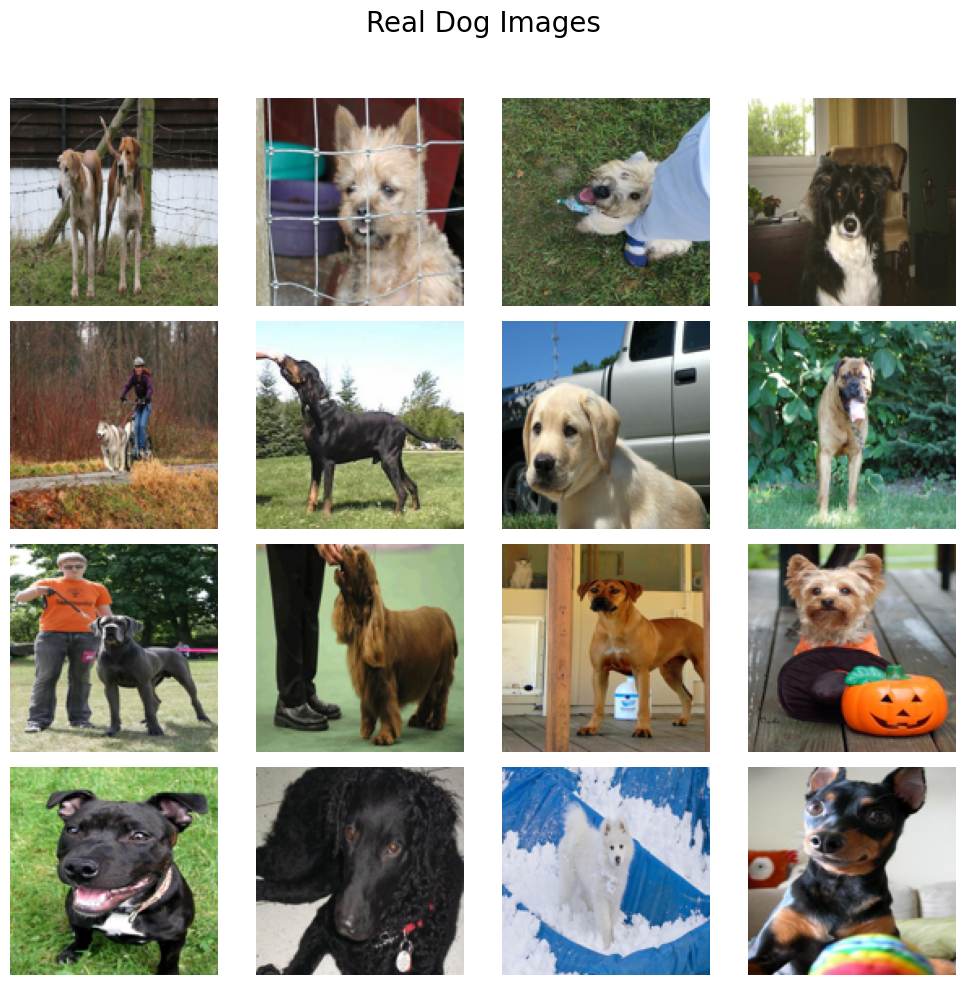

In [4]:
plot_images(data_path, 'Real Dog Images')

In [5]:
image_size = 64
latent_size = 128
batch_size = 128
epochs = 25
lr = 0.0002

dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=(image_size, image_size),
    batch_size=batch_size,
    label_mode=None
)
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

Found 20580 files belonging to 1 classes.


In [6]:
def Generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_size,)),
        layers.Reshape((1, 1, latent_size)),

        layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh')
    ])
    return model

In [7]:
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         1048576   
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097152   
 Transpose)                                                      
                                                        

In [8]:
def Discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(1, (4, 4), padding='valid', use_bias=False),
        layers.Flatten(),
        layers.Activation('sigmoid')
    ])
    return model

In [9]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_5 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)      

In [17]:
class GAN:
    def __init__(self, generator, discriminator, batch_size, latent_size, generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5), discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)):
        self.generator = generator
        self.discriminator = discriminator
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.batch_size = batch_size
        self.latent_size = latent_size
        # initialize the loss functions
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def generator_loss(self, fake_output):
        # all fake images should be classified as real (1)
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output):
        # real images should be classified as real (1), fake images as fake (0)
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.batch_size, self.latent_size])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    def train(self, dataset, epochs):
        for epoch in range(epochs):
            for image_batch in dataset:
                self.train_step(image_batch)

In [18]:
gan = GAN(generator, discriminator, batch_size, latent_size)

In [19]:
gan.train(dataset, epochs)

In [20]:
def generate_and_save_images(generator, latent_size, num_samples=16, save_dir='generated_images'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    sample_noise = tf.random.normal([num_samples, latent_size])
    sample_images = generator(sample_noise, training=False)
    sample_images = 0.5 * sample_images + 0.5
    sample_images = np.clip(sample_images.numpy(), 0, 1)

    for i in range(num_samples):
        img_filename = f'image_{i+1}.png'
        plt.imsave(os.path.join(save_dir, img_filename), sample_images[i])

    return save_dir

In [21]:
gen_path = generate_and_save_images(generator, latent_size)

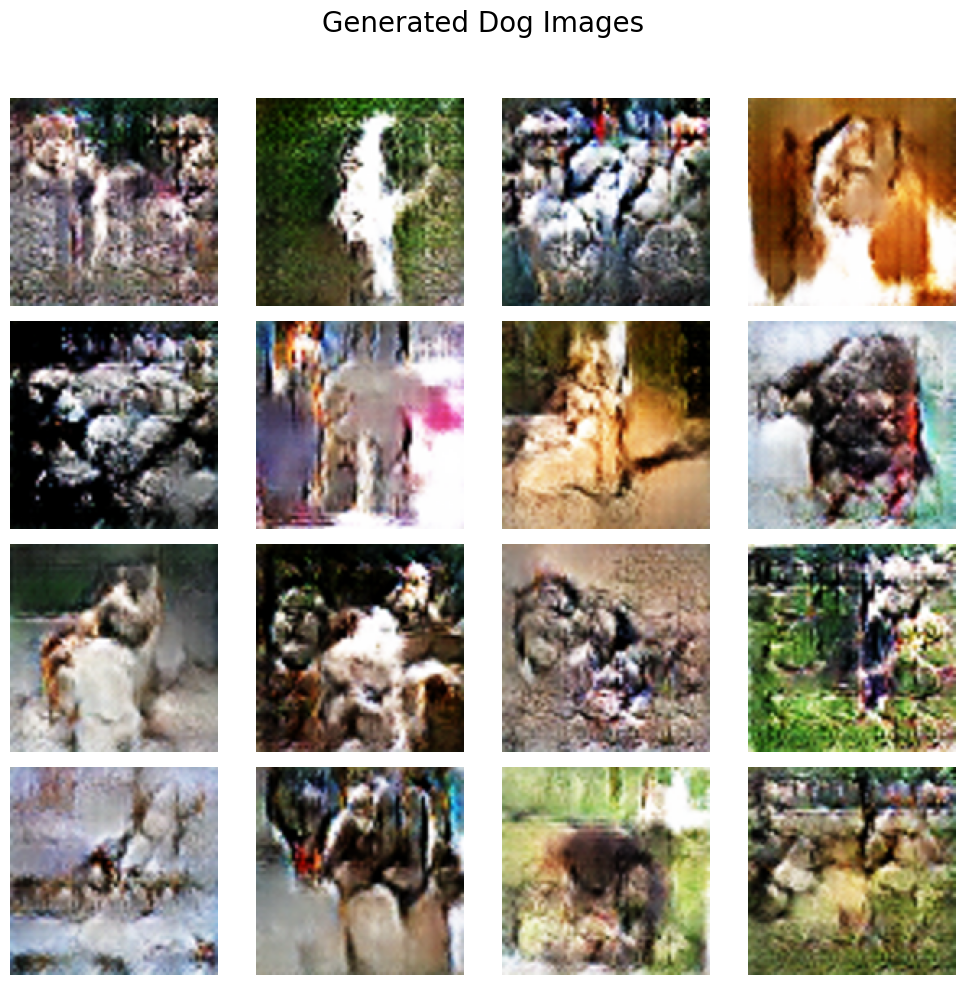

In [22]:
plot_images(gen_path, 'Generated Dog Images')